In [1]:
import sys
import os

# Add the outer mcerp folder (the one containing the inner mcerp package)
print(os.getcwd())
module_path = os.path.abspath("mcerp")
os.chdir(module_path)
print(os.getcwd())

import mcerp
print(mcerp.correlation_matrix)


c:\Users\AUSM504495\Documents\GitHub\WSP_PSI
c:\Users\AUSM504495\Documents\GitHub\WSP_PSI\mcerp


c:\Users\AUSM504495\Documents\GitHub\WSP_PSI\mcerp\mcerp\__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


<function correlation_matrix at 0x0000025362E04360>


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mcerp import correlate
from mcerp import correlation_matrix
from mcerp.correlate import plotcorr
from mcerp import Beta, N, Exp, PERT
from mcerp import uv, stats
# from mcerp import *

from scipy import stats as stats
from scipy.stats import rv_continuous, beta, genextreme, rv_histogram
import scipy.optimize as opt


import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

nR = 10000

In [3]:
# distribution parameters:
min, mode, max, lmb = 8000.0, 12000.0, 18000.0, 4.0         # sales volume, PERT estimae
ms, ss = 20.0, 1.0                                          # selling price, normally distributed
mm, sm = 13.0, 0.7                                          # material unit cost, normally distributed 
o = 3.0                                                     # other unit cost, deterministic 

In [4]:
# setting up the simulation model BEFORE calibrating correlations:

# input variables:
v1 = PERT(min, mode, max, lmb)                  # sales volume, PERT distributed
p1 = N(ms, ss)                                  # selling price, normally distributed
m1 = N(mm, sm)                                  # material unit cost, normally distributed 
o1 = o                                          # other unit cost, deterministic    


# output variables:
GP1 = v1 * (p1 - m1 - o1)                       # simulation output: Gross Profit
R1 = v1 * p1                                    # simulation output: Revenues
GM1 = GP1 / R1                                  # simulation output: Gross Margin
C1 = R1 - GP1                                   # simulation output: Total Cost

In [5]:
# run the simulation model, 
# and collect the results in array variables

# number of mcerp samples
npts = nR

# assign the 6x 10,000 values to 6 variables so we can process their arrays later
rv1 = v1._mcpts
rp1 = p1._mcpts
rm1 = m1._mcpts
rGP1 = GP1._mcpts
rR1 = R1._mcpts
rGM1 = GM1._mcpts

# combine the 6 arrays in a 2-dimensional array
rand1 = np.vstack((rv1, rp1, rm1, rGP1, rR1, rGM1))

# copy the array to a dataframe for a more transparent layout
df1 = pd.DataFrame(data=rand1).T 
df1.rename(columns={ 
    0:"volume 1", 1:"price 1", 2:"material 1", 3:"Gross Profit 1", 4:"Revenues 1", 5:"Gross Margin 1"}, 
    inplace=True)
df1

,volume 1,price 1,material 1,Gross Profit 1,Revenues 1,Gross Margin 1
0,11379.720,19.242,13.762,28225.333,218973.356,0.129
1,11521.108,20.649,13.431,48597.306,237904.738,0.204
2,12895.798,18.456,12.928,32609.511,238009.337,0.137
3,15170.009,19.930,13.268,55548.184,302335.694,0.184
4,10612.096,19.842,14.056,29566.655,210568.648,0.140
...,...,...,...,...,...,...
9995,15843.606,21.018,13.212,76151.357,333001.118,0.229
9996,14948.220,20.351,13.926,51201.845,304212.873,0.168
9997,11774.472,21.067,13.639,52139.604,248050.157,0.210
9998,15420.048,18.106,13.394,26399.639,279200.611,0.095


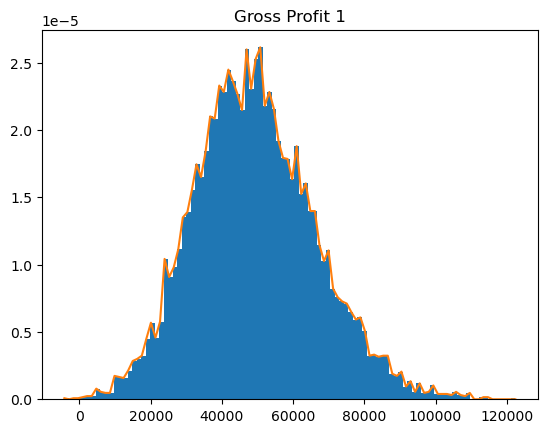

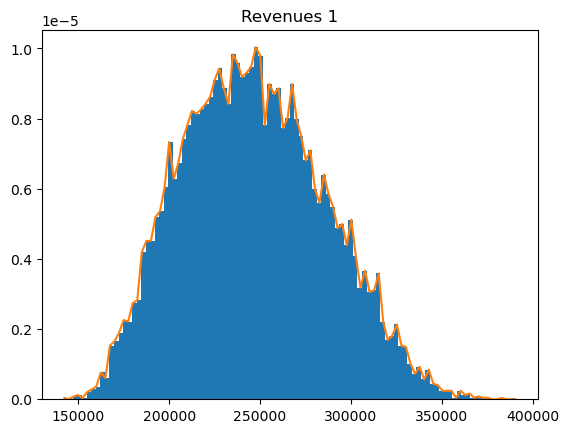

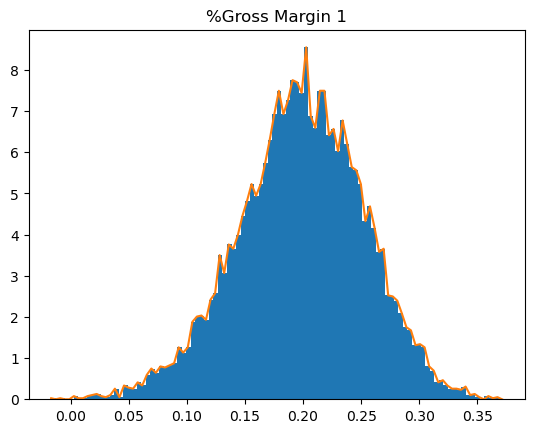

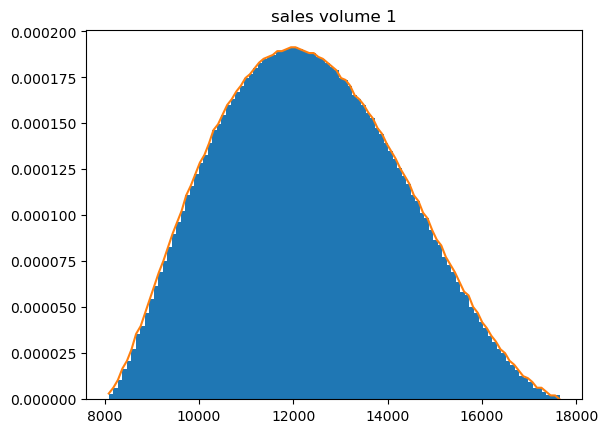

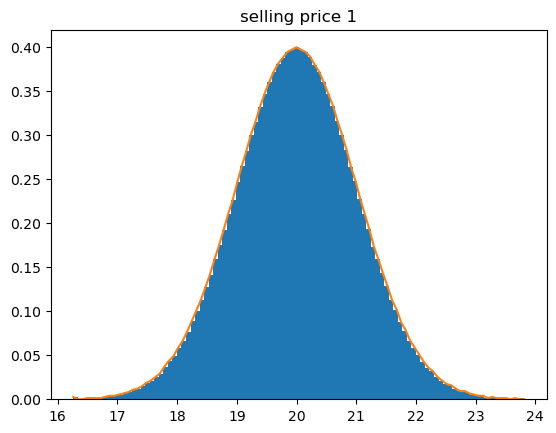

In [6]:
# helper function: plot histogram
def plot_hist(data, title):
    hist = np.histogram(data, bins=100)
    histdist = rv_histogram(hist)

    X = np.linspace(data.min(), data.max(), 100)
    plt.title(title)
    plt.hist(data, density=True, bins=100)
    plt.plot(X, histdist.pdf(X))
    plt.show()
    
    
    # results: draw histograms
plot_hist(rGP1, "Gross Profit 1")
plot_hist(rR1, "Revenues 1")
plot_hist(rGM1, "%Gross Margin 1")
plot_hist(rv1, "sales volume 1")
plot_hist(rp1, "selling price 1")

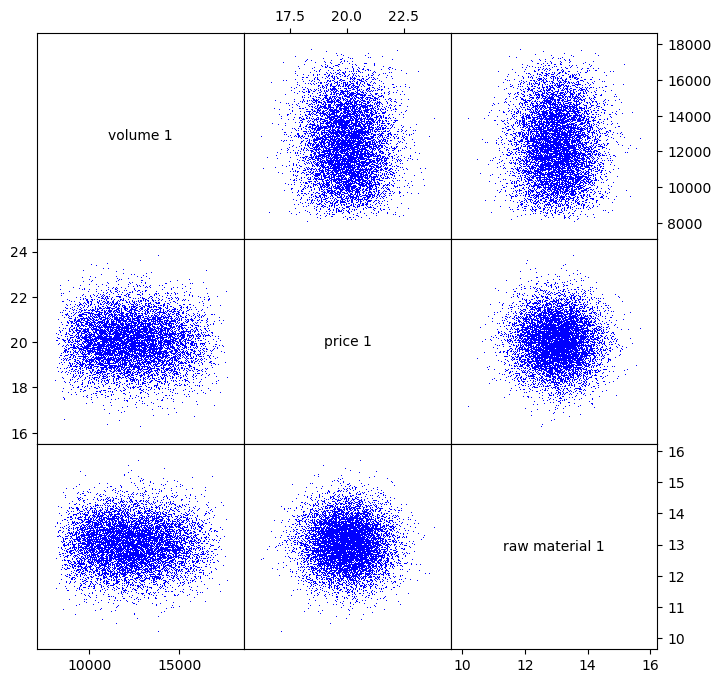

In [7]:
# get the correlation matrix BEFORE recalibrating
c1 = correlation_matrix([v1, p1, m1])
c1

# plot correlations BEFORE recalibrating
corrplot0 = plotcorr([v1, p1, m1], labels=["volume 1", "price 1", "raw material 1"])

In [12]:
# targeted correlation matrix: volume, price, material unit cost
c_target = np.array(    [[  1.0, -0.3,  0.2],
                        [  -0.3,  1.0,  0.7],
                        [   0.2,  0.7,  1.0]])

# impose the targeted correlation matrix on the 3 input variables
v2=v1
p2=p1
m2=m1
o2=o1
correlate([v2, p2, m2], c_target)

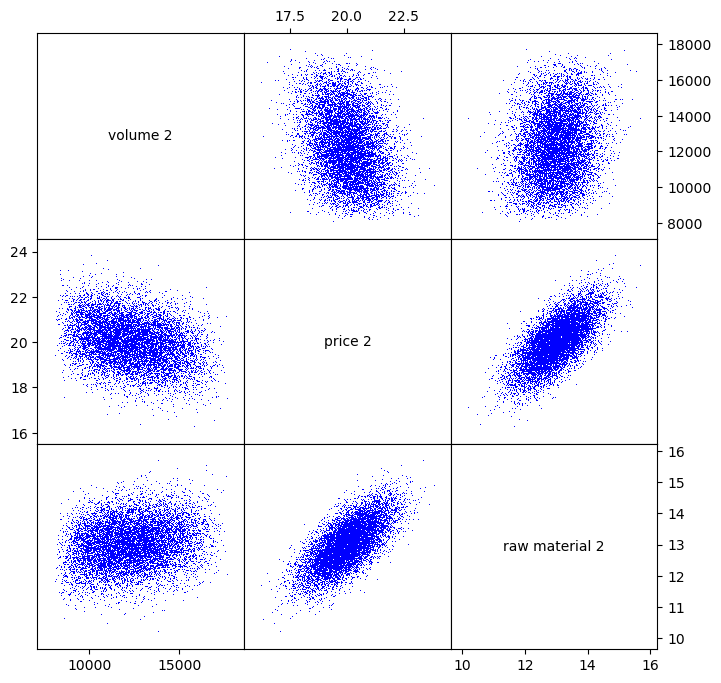

In [13]:
c2 = correlation_matrix([v2, p2, m2])
c2

# deviations from targeted correlations
c2 - c_target

# plot the new correlation matrix of the input variables
corrplot2 = plotcorr([v2, p2, m2], labels=["volume 2", "price 2", "raw material 2"])

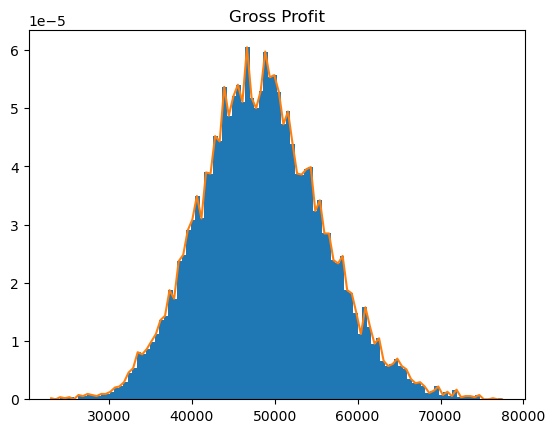

In [14]:
# output variables:
# we rename the output variables to use consistent variable names in simu1 and simu2
GP2 = v2 * (p2 - m2 - o2)                       # simulation output: Gross Profit
R2 = v2 * p2                                    # simulation output: Revenues
GM2 = GP2 / R2                                  # simulation output: Gross Margin
C2 = R2 - GP2                                   # simulation output: Total Cost

# assign the 6x 10,000 variates to 6 variables so we can process their arrays later
rv2 = v2._mcpts
rp2 = p2._mcpts
rm2 = m2._mcpts
rGP2 = GP2._mcpts
rR2 = R2._mcpts
rGM2 = GM2._mcpts

# combine the 6 arrays in a 2-dimensional array
rand2 = np.vstack((rv2, rp2, rm2, rGP2, rR2, rGM2))

# copy the array to a dataframe for a more transparent layout
df2 = pd.DataFrame(data=rand2).T 
df2.rename(columns={ 
    0:"volume 2", 1:"price 2", 2:"material 2", 3:"Gross Profit 2", 4:"Revenues 2", 5:"Gross Margin 2"}, 
    inplace=True)
df2

# results: draw histograms
plot_hist(rGP2, "Gross Profit")